# 4. Forecast Analysis & Hypothesis Testing

## 1. Load Data

In [1]:
import mxnet as mx
from mxnet import nd, sym
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [2]:
devices = {0: {'hh': 'hh1', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          1: {'hh': 'hh1', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          2: {'hh': 'hh2', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          3: {'hh': 'hh2', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          4: {'hh': 'hh3', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          5: {'hh': 'hh3', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          6: {'hh': 'hh3', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          7: {'hh': 'hh4', 'dev_name': 'Washing Machine (1)', 'dev': 'washing_machine'},
          8: {'hh': 'hh4', 'dev_name': 'Washing Machine (2)', 'dev': 'washing_machine'},
          9: {'hh': 'hh5', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          10: {'hh': 'hh6', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          11: {'hh': 'hh6', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          12: {'hh': 'hh7', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          13: {'hh': 'hh7', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          14: {'hh': 'hh7', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          15: {'hh': 'hh8', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          16: {'hh': 'hh9', 'dev_name': 'Washer Dryer', 'dev': 'washer_dryer'},
          17: {'hh': 'hh9', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          18: {'hh': 'hh9', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          19: {'hh': 'hh10', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          }


In [3]:
import os
DATA_PATH = os.getcwd()+'/data/'
PICKLE_PATH = os.getcwd()+'/data/pickle_files'


In [4]:
from helper_functions_thesis import Helper_Functions_Thesis
from helper_functions import Helper
helper = Helper()

load_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'load_dict.pickle')
activity_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'activity_dict.pickle')
usage_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'usage_dict.pickle')
price_df = helper.create_day_ahead_prices_df(DATA_PATH,'Day-ahead Prices_201501010000-201601010000.csv')

In [5]:
start_dataset = '2014-03-01'
end_dataset = '2015-05-07'

In [6]:
from Thesis_Classes import Create_Dataset
create_dataset = Create_Dataset(start_dataset, end_dataset, devices, load_dict, usage_dict, activity_dict)
dataset_dict = create_dataset.pipeline()
dataset_dict[0].head(3)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,usage,usage_bin,hh,dev,periods_since_last_activity,periods_since_last_usage,activity_prob,usage_prob,temp,dwpt,rhum,wdir,wspd
2014-03-01 00:00:00,0.0,0,hh1,washing_machine,36.0,37.0,0.002775,0.004596,0.819444,0.518519,0.548148,0.571429,0.609412
2014-03-01 01:00:00,0.0,0,hh1,washing_machine,36.0,37.0,0.002864,0.004596,0.819444,0.518519,0.548148,0.571429,0.609412
2014-03-01 02:00:00,0.0,0,hh1,washing_machine,36.0,37.0,0.003443,0.004596,0.819444,0.518519,0.548148,0.571429,0.609412


## 2. Generating Counterfactual Scenarios from Binary Forecasts

In the second Jupyter Notebook, we discussed the process of generating binary predictions using the trained DeepAR model. The final step in creating counterfactual scenarios based on these forecasts is to incorporate the actual device loads during the hours when device usage is predicted. With the **'Create_Counterfactual_Time_Series'** class, we create realistic counterfactual scenarios by shifting consumers' device usage based on the actual usage and historical data. 

Once the recommendation system is fully implemented, one will only have usage data impacted by the recommendation system. Since the system is designed to decrease costs through load shifting and not load curtailing, using data which will be influenced by the recommendation system to create counterfactual usage patterns poses no issue for the evaluation proces.

In our current testing phase, we're evaluating the recommendation system prior to its implementation. Given that the usage data with recommendations is simulated from data without them, we directly use the data without recommendations to create counterfactual scenarios.

### 2.1 Initialize the class

We introduce the **'Create_Counterfactual_Time_Series'** class and initialize it with the necessary input parameters.

In [7]:
from Thesis_Classes import Generate_Forecasts

recommendation_start = '2015-02-01'
recommendation_phase = 96

forecast_samples = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'forecast_samples_rescaled.pickle')
forecast = Generate_Forecasts.create_forecast_quantiles(forecast_samples)
target = Helper_Functions_Thesis.create_target_values(recommendation_start,recommendation_phase, dataset_dict, binary_usage = False)

In [8]:
from typing import Dict, List, Any, Tuple
import pandas as pd
class Create_Counterfactual_Time_Series:
    '''
    A class for generating counterfactual load usage patterns from binary forecasts
    Parameters:
    ----------
    forecast
        A dictionary of forecasted dataframes for each device
    forecast_samples
        A Forecast object, where the predicted distribution is represented internally as samples
    target
        A dictionary of target dataframes for each device
    devices
        A dictionary containing device-specific information
    price_df
         A DataFrame with hourly price data in GBP per megawatt-hour.
    '''
    def __init__(
        self,
        forecast_samples,
        forecast: Dict[str, pd.DataFrame],
        target: Dict[str, pd.DataFrame],
        devices: Dict[str, Any],
        price_df: pd.DataFrame,

    ):
        import numpy as np
        self.forecast_samples = forecast_samples
        self.forecast =  {dev: df.copy() for dev, df in forecast.items()}
        self.target = {dev: df.copy() for dev, df in target.items()} 
        self.devices = devices
        self.date_list = np.unique(next(iter(self.forecast.values())).index.date)
        self.price_df = price_df

In [9]:
create_counterfactuals = Create_Counterfactual_Time_Series(
    forecast_samples,
    forecast,
    target,
    devices,
    price_df)

### 2.2 Create Load Profiles

With the **add_load_profile** method, we utilize the Load Agent and generate load profiles that provide the hourly average load of shiftable appliances. These average values serve as a reference for periods when usage is forecasted but no actual usage occurs. To create authentic usage patterns, we employ load profiles matching the forecasted usage duration.

We place this method outside of the **Create_Counterfactual_Time_Series** because we don't need to run it each time we create counterfactual time series. The function can be found in the **Helper_Functions_Thesis** class

In [10]:
def add_load_profile(devices, recommendation_start, load_dict):
    from agents import Load_Agent
    from helper_functions_thesis import Helper_Functions_Thesis
    from copy import deepcopy
    
    devices_with_loads = deepcopy(devices)
        
    shiftable_devices_dict = Helper_Functions_Thesis.create_shiftable_devices_dict(devices_with_loads)

    load_profiles_dict = {}
    for hh in shiftable_devices_dict.keys():
        
        # Load profile calculated from data start until chosen date (recommendation start)
        load_agent = Load_Agent(hh[2:])
        load_profiles_dict[hh] = load_agent.pipeline(load_dict[hh], recommendation_start, shiftable_devices_dict[hh])
            
    for dev in devices_with_loads.keys():
        
        hh = devices_with_loads[dev]['hh']
        dev_name = devices_with_loads[dev]['dev_name']
        devices_with_loads[dev]['load_profile'] = load_profiles_dict[hh].loc[dev_name]
        
    return devices_with_loads
        

In [11]:
create_counterfactuals.devices = add_load_profile(devices, recommendation_start, load_dict)

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a

### 2.3 Counterfactual Scenario Generation

The creation of counterfactual time series is a crucial step in assessing the recommendation system's effectiveness. In the following sections, we introduce the key functions that collectively generate counterfactual time series.

#### 2.3.1 Function Setup for Counterfactual Usage Generation

We introduce a set of auxiliary functions designed to enhance the readability and modularity of the main algorithm. These specialized functions help break down the complex tass into more manageable and understandable code components. 

##### _calculate_usage_length

This method calculates the length of device usage by determining the time span between non-zero values in the data.

In [12]:
def _calculate_usage_length(self, data, start_dataset):
    import pandas as pd
    return (
        ((data.iloc[start_dataset:] == 0).idxmax() - data.index[start_dataset])
            // pd.Timedelta(minutes=60)
        )[0]
        
setattr(Create_Counterfactual_Time_Series, '_calculate_usage_length', _calculate_usage_length)
del _calculate_usage_length

##### _insert_usage_values_from_target

This method inserts electricity consumption values into the forecasted binary usage pattern, based on the real device usage on the forecasted day. This involves aligning the target usage with the forecasted usage, considering time shifts and filling gaps with corresponding values. We determine the duration of the real usage and shift the load values to the nearest forecast start hour. We update the forecast data and adjust the forecasted usage for the corresponding timeframe to prevent double-counting.Finally, we combine the  time-shifted target usage with the counterfactual forecasted dataframe. 

In [13]:
def _insert_usage_values_from_target(
    self,
    daily_forecast_extended,
    daily_target_extended,
    start_hours_forecast,
    target_start_hour,
    load_profile,
):
    import pandas as pd
        
    nearest_forecast_start_hour = min(
        start_hours_forecast, key=lambda x: abs(x - target_start_hour)
    )

    time_shift = nearest_forecast_start_hour - target_start_hour

    usage_length_target = self._calculate_usage_length(
        daily_target_extended, target_start_hour
    )
    usage_length_forecast = self._calculate_usage_length(
        daily_forecast_extended, nearest_forecast_start_hour
    )
    
    usage_length_forecast = min(usage_length_forecast,24)

    target_hours_pre_shift = daily_target_extended.iloc[
        target_start_hour:target_start_hour + usage_length_forecast
    ]
    
    target_hours_post_shift = target_hours_pre_shift.shift(periods=time_shift, freq="60T")
    if usage_length_forecast > usage_length_target:

        target_hours_post_shift.iloc[
            usage_length_target: min(usage_length_forecast,len(target_hours_post_shift)),0
        ] = load_profile[usage_length_target:min(usage_length_forecast,len(target_hours_post_shift))]
    
    daily_forecast_extended.iloc[
        nearest_forecast_start_hour:nearest_forecast_start_hour
        + usage_length_forecast
    ] = 0
    daily_forecast_extended = target_hours_post_shift.combine_first(
        daily_forecast_extended
    )

    start_hours_forecast.remove(nearest_forecast_start_hour)
    
    return daily_forecast_extended, start_hours_forecast

setattr(Create_Counterfactual_Time_Series, '_insert_usage_values_from_target', _insert_usage_values_from_target)
del _insert_usage_values_from_target

##### _insert_usage_values_from_load_profile
This method serves a comparable purpose to **'_insert_usage_values_from_target'** method. The function determines the duration of the forecasted usage and incorporates electricity consumption values from the device specific load profiles. 

In [14]:
def _insert_usage_values_from_load_profile(
    self,
    load_profile,
    daily_forecast_extended,
    forecast_start_dataset,
):
    usage_length_forecast = self._calculate_usage_length(
        daily_forecast_extended, forecast_start_dataset
    )
    
    daily_forecast_extended.iloc[
        forecast_start_dataset:forecast_start_dataset
        + usage_length_forecast,
        0,
    ] = load_profile[0:usage_length_forecast]
        
    return daily_forecast_extended

setattr(Create_Counterfactual_Time_Series, '_insert_usage_values_from_load_profile', _insert_usage_values_from_load_profile)
del _insert_usage_values_from_load_profile

#### 2.3.2 Counterfactual Time Series Generation Algorithm

The **'create_counterfactual_time_series'** method utilizes the previously described methods and iterates through each device and day within the forecasted time span to generate counterfactual time series. For each day where there is a usage prediction, the function incorporates load values from either the actual target data or the device's load profile, or even both, as needed. 

If usage is present in both the forecast and target data, the function determines the usage start hours for each, and shifts the target values to the closest prediction hour. Moreover, it takes into account the usage patterns that span overnight by analyzing data from the day before and after, ensuring seamless insertion without disrupting the usage continuity.

Ultimately, the function combines the daily adjusted usage values to generate the counterfactual time series output for each device. The results are then combined and returned in a dictionary format.

In [15]:
def create_counterfactual_time_series(self, is_info_displayed=False):
    # Import necessary libraries
    from datetime import timedelta
    import pandas as pd
    
    results = {}
    
    # Iterate through each device
    for dev in self.devices.keys():
        forecast = self.forecast[dev].copy()
        target = self.target[dev]
        load_profile = self.devices[dev]['load_profile']
        
        # Initialize an output DataFrame
        output = pd.DataFrame(index=forecast.index, columns=['usage'])
        
        if is_info_displayed:
            print('\n', 'device nr: ', dev)
        
        # Iterate over each date in the specified date list
        for date in self.date_list:
            date_before = date - timedelta(days=1)
            date = str(date)

            # Extract daily forecast and target data
            daily_forecast = forecast.loc[date]
            daily_target = target.loc[date]

            daily_target_extended = target.loc[date:][:48]
            daily_forecast_extended = forecast.loc[date:][:48]

            # Check if there is device usage on the forecast day
            if daily_forecast.values.sum() == 0:
                if is_info_displayed:
                    print(date, "no device usage forecasted")
                continue

            # Create shifted versions of daily forecast and target to calculate start hours
            shifted_daily_forecast = daily_forecast.shift()
            shifted_daily_target = daily_target.shift()
                
            if date != str(self.date_list[0]):
                shifted_daily_forecast.iloc[0] = forecast.loc[str(date_before)].iloc[-1]
                shifted_daily_target.iloc[0] = target.loc[str(date_before)].iloc[-1]
                
            start_hours_forecast = daily_forecast[
                (daily_forecast.values == 1) & (shifted_daily_forecast.values == 0)
            ].index.hour.tolist()

            # Continue only if there is usage start on the forecast day
            if start_hours_forecast == []:
                continue

            # Identify the start hours for device usage in target
            start_hours_target = daily_target[
                (daily_target.values > 0) & (shifted_daily_target.values == 0)
            ].index.hour.tolist()

            # Sort target start hours based on proximity to forecast start hours
            sorted_start_hours_target = sorted(
                start_hours_target,
                key=lambda x: min(abs(x - r) for r in start_hours_forecast),
            )
            
            if is_info_displayed:
                if len(start_hours_target) > len(start_hours_forecast):
                    print(date, 'More device start hours than forecasted')
                else:
                    print(date, 'Less than or equal device start hours than forecasted')
                    
            # Iterate through sorted target start hours
            for target_start_hour in sorted_start_hours_target:
                if start_hours_forecast == []:
                    break
                
                # Insert target usage values into forecast
                daily_forecast_extended, start_hours_forecast = self._insert_usage_values_from_target(
                    daily_forecast_extended,
                    daily_target_extended,
                    start_hours_forecast,
                    target_start_hour,
                    load_profile,
                )

            # Handle remaining start hours by inserting load profile data
            for forecast_start_dataset in start_hours_forecast:
                if daily_forecast_extended['usage'].iloc[forecast_start_dataset] <= 1:
                    daily_forecast_extended = self._insert_usage_values_from_load_profile(
                        load_profile,
                        daily_forecast_extended,
                        forecast_start_dataset,
                    )
                    
            # Combine daily adjusted usage values into the output DataFrame
            output = daily_forecast_extended[daily_forecast_extended['usage'] > 1].combine_first(output)
                
        results[dev] = output.fillna(0)

    return results

setattr(Create_Counterfactual_Time_Series, 'create_counterfactual_time_series', create_counterfactual_time_series)
del create_counterfactual_time_series


In [16]:
counterfactual_usage = create_counterfactuals.create_counterfactual_time_series(is_info_displayed=True)



 device nr:  0
2015-02-01 Less than or equal device start hours than forecasted
2015-02-02 no device usage forecasted
2015-02-03 no device usage forecasted
2015-02-04 no device usage forecasted
2015-02-05 Less than or equal device start hours than forecasted
2015-02-06 Less than or equal device start hours than forecasted
2015-02-07 no device usage forecasted
2015-02-08 Less than or equal device start hours than forecasted
2015-02-09 no device usage forecasted
2015-02-10 no device usage forecasted
2015-02-11 no device usage forecasted
2015-02-12 no device usage forecasted
2015-02-13 Less than or equal device start hours than forecasted
2015-02-14 no device usage forecasted
2015-02-15 Less than or equal device start hours than forecasted
2015-02-16 no device usage forecasted
2015-02-17 Less than or equal device start hours than forecasted
2015-02-18 Less than or equal device start hours than forecasted
2015-02-19 no device usage forecasted
2015-02-20 Less than or equal device start hou

2015-03-04 Less than or equal device start hours than forecasted
2015-03-05 Less than or equal device start hours than forecasted
2015-03-06 Less than or equal device start hours than forecasted
2015-03-07 no device usage forecasted
2015-03-08 no device usage forecasted
2015-03-09 Less than or equal device start hours than forecasted
2015-03-10 no device usage forecasted
2015-03-11 Less than or equal device start hours than forecasted
2015-03-12 no device usage forecasted
2015-03-13 Less than or equal device start hours than forecasted
2015-03-14 Less than or equal device start hours than forecasted
2015-03-15 Less than or equal device start hours than forecasted
2015-03-16 no device usage forecasted
2015-03-17 Less than or equal device start hours than forecasted
2015-03-18 Less than or equal device start hours than forecasted
2015-03-19 no device usage forecasted
2015-03-20 Less than or equal device start hours than forecasted
2015-03-21 Less than or equal device start hours than for

2015-03-17 Less than or equal device start hours than forecasted
2015-03-18 Less than or equal device start hours than forecasted
2015-03-19 Less than or equal device start hours than forecasted
2015-03-20 no device usage forecasted
2015-03-21 no device usage forecasted
2015-03-22 no device usage forecasted
2015-03-23 no device usage forecasted
2015-03-24 Less than or equal device start hours than forecasted
2015-03-25 no device usage forecasted
2015-03-26 Less than or equal device start hours than forecasted
2015-03-27 no device usage forecasted
2015-03-28 Less than or equal device start hours than forecasted
2015-03-29 no device usage forecasted
2015-03-30 Less than or equal device start hours than forecasted
2015-03-31 no device usage forecasted
2015-04-01 no device usage forecasted
2015-04-02 Less than or equal device start hours than forecasted
2015-04-03 no device usage forecasted
2015-04-04 no device usage forecasted
2015-04-05 no device usage forecasted
2015-04-06 no device usa

2015-04-13 Less than or equal device start hours than forecasted
2015-04-14 Less than or equal device start hours than forecasted
2015-04-15 Less than or equal device start hours than forecasted
2015-04-16 no device usage forecasted
2015-04-17 no device usage forecasted
2015-04-18 More device start hours than forecasted
2015-04-19 Less than or equal device start hours than forecasted
2015-04-20 Less than or equal device start hours than forecasted
2015-04-21 Less than or equal device start hours than forecasted
2015-04-22 Less than or equal device start hours than forecasted
2015-04-23 no device usage forecasted
2015-04-24 Less than or equal device start hours than forecasted
2015-04-25 Less than or equal device start hours than forecasted
2015-04-26 no device usage forecasted
2015-04-27 Less than or equal device start hours than forecasted
2015-04-28 Less than or equal device start hours than forecasted
2015-04-29 no device usage forecasted
2015-04-30 Less than or equal device start h

2015-03-30 no device usage forecasted
2015-03-31 no device usage forecasted
2015-04-01 no device usage forecasted
2015-04-02 no device usage forecasted
2015-04-03 no device usage forecasted
2015-04-04 no device usage forecasted
2015-04-05 no device usage forecasted
2015-04-06 no device usage forecasted
2015-04-07 no device usage forecasted
2015-04-08 Less than or equal device start hours than forecasted
2015-04-09 Less than or equal device start hours than forecasted
2015-04-10 Less than or equal device start hours than forecasted
2015-04-11 Less than or equal device start hours than forecasted
2015-04-12 no device usage forecasted
2015-04-13 no device usage forecasted
2015-04-14 no device usage forecasted
2015-04-15 no device usage forecasted
2015-04-16 no device usage forecasted
2015-04-17 no device usage forecasted
2015-04-18 Less than or equal device start hours than forecasted
2015-04-19 no device usage forecasted
2015-04-20 no device usage forecasted
2015-04-21 no device usage fo

2015-03-01 Less than or equal device start hours than forecasted
2015-03-02 Less than or equal device start hours than forecasted
2015-03-03 Less than or equal device start hours than forecasted
2015-03-04 Less than or equal device start hours than forecasted
2015-03-05 no device usage forecasted
2015-03-06 Less than or equal device start hours than forecasted
2015-03-07 no device usage forecasted
2015-03-08 Less than or equal device start hours than forecasted
2015-03-09 Less than or equal device start hours than forecasted
2015-03-10 no device usage forecasted
2015-03-11 Less than or equal device start hours than forecasted
2015-03-12 no device usage forecasted
2015-03-13 Less than or equal device start hours than forecasted
2015-03-14 Less than or equal device start hours than forecasted
2015-03-15 Less than or equal device start hours than forecasted
2015-03-16 Less than or equal device start hours than forecasted
2015-03-17 Less than or equal device start hours than forecasted
201

2015-02-03 Less than or equal device start hours than forecasted
2015-02-04 Less than or equal device start hours than forecasted
2015-02-05 Less than or equal device start hours than forecasted
2015-02-06 Less than or equal device start hours than forecasted
2015-02-07 Less than or equal device start hours than forecasted
2015-02-08 no device usage forecasted
2015-02-09 Less than or equal device start hours than forecasted
2015-02-10 Less than or equal device start hours than forecasted
2015-02-11 Less than or equal device start hours than forecasted
2015-02-12 Less than or equal device start hours than forecasted
2015-02-13 no device usage forecasted
2015-02-14 Less than or equal device start hours than forecasted
2015-02-15 no device usage forecasted
2015-02-16 no device usage forecasted
2015-02-17 Less than or equal device start hours than forecasted
2015-02-18 no device usage forecasted
2015-02-19 no device usage forecasted
2015-02-20 no device usage forecasted
2015-02-21 Less tha

2015-03-06 Less than or equal device start hours than forecasted
2015-03-07 Less than or equal device start hours than forecasted
2015-03-08 Less than or equal device start hours than forecasted
2015-03-09 Less than or equal device start hours than forecasted
2015-03-10 no device usage forecasted
2015-03-11 no device usage forecasted
2015-03-12 no device usage forecasted
2015-03-13 no device usage forecasted
2015-03-14 no device usage forecasted
2015-03-15 no device usage forecasted
2015-03-16 no device usage forecasted
2015-03-17 no device usage forecasted
2015-03-18 Less than or equal device start hours than forecasted
2015-03-19 no device usage forecasted
2015-03-20 no device usage forecasted
2015-03-21 Less than or equal device start hours than forecasted
2015-03-22 Less than or equal device start hours than forecasted
2015-03-23 no device usage forecasted
2015-03-24 no device usage forecasted
2015-03-25 no device usage forecasted
2015-03-26 no device usage forecasted
2015-03-27 no

2015-03-10 Less than or equal device start hours than forecasted
2015-03-11 Less than or equal device start hours than forecasted
2015-03-12 no device usage forecasted
2015-03-13 Less than or equal device start hours than forecasted
2015-03-14 Less than or equal device start hours than forecasted
2015-03-15 Less than or equal device start hours than forecasted
2015-03-16 Less than or equal device start hours than forecasted
2015-03-17 Less than or equal device start hours than forecasted
2015-03-18 Less than or equal device start hours than forecasted
2015-03-20 Less than or equal device start hours than forecasted
2015-03-21 Less than or equal device start hours than forecasted
2015-03-22 no device usage forecasted
2015-03-23 no device usage forecasted
2015-03-24 no device usage forecasted
2015-03-25 no device usage forecasted
2015-03-26 Less than or equal device start hours than forecasted
2015-03-27 Less than or equal device start hours than forecasted
2015-03-28 Less than or equal 

### 2.4 Calculating Costs

The **'calculate_total_cost'** method creates a new dataframe where the hourly electricity loads and price data are merged. These variables are used to compute the cost of device usage on an hourly basis.

In [17]:
def calculate_total_cost(self, usage_df):
    import pandas as pd
    usage_df = pd.DataFrame(usage_df)
    usage_df = usage_df.join(self.price_df, how="inner")
    usage_df["total_cost"] = usage_df["usage"] * usage_df["Price"]

    return usage_df

setattr(Create_Counterfactual_Time_Series, 'calculate_total_cost', calculate_total_cost)
del calculate_total_cost

### 2.5 Aggregating the Time Series

The methods below aim to aggregate the time series at different levels of granularity by taking the means.
Aggregation can be carried out at different levels, such as device and household levels, or be executed comprehensively, encompassing all data. Additionally, the option exists to include daily summaries during the aggregation process, which can be combined with any of the mentioned levels, providing a versatile means of examining electricity consumption patterns.

##### Aggregation at daily level

In [18]:
def agg_to_day_level(self, time_series):
    import pandas as pd
    agg_time_series = {}
    for i in time_series.keys():
        agg_time_series[i] = 0
        agg_time_series[i] = time_series[i].groupby(pd.Grouper(freq='D')).sum()

    return agg_time_series

setattr(Create_Counterfactual_Time_Series, 'agg_to_day_level', agg_to_day_level)
del agg_to_day_level

##### Aggregation at device level

In [19]:
def agg_to_dev_level(self, time_series):
    import numpy as np
    agg_time_series = {}
    count_per_dev = {}

    for dev in np.unique([self.devices[x]["dev"] for x in self.devices.keys()]):
        agg_time_series[dev] = 0
        count_per_dev[dev] = 0

        for i in [x for x in self.devices.keys() if self.devices[x]["dev"] == dev]:
            agg_time_series[dev] += time_series[i]
            count_per_dev[dev] += 1  # Increment the count for this device

        agg_time_series[dev] /= count_per_dev[dev]

    return agg_time_series

setattr(Create_Counterfactual_Time_Series, 'agg_to_dev_level', agg_to_dev_level)
del agg_to_dev_level



##### Aggregation at household level

In [20]:
def agg_to_hh_level(self, time_series):
    import numpy as np
    agg_time_series = {}
    count_per_hh = {}
    for hh in np.unique([self.devices[x]["hh"] for x in self.devices.keys()]):
        agg_time_series[hh] = 0
        count_per_hh[hh] = 0

        for i in [x for x in self.devices.keys() if self.devices[x]["hh"] == hh]:
            agg_time_series[hh] += time_series[i]
            count_per_hh[hh] += 1
        
        agg_time_series[hh] /= count_per_hh[hh]

    return agg_time_series

setattr(Create_Counterfactual_Time_Series, 'agg_to_hh_level', agg_to_hh_level)
del agg_to_hh_level

##### Aggregation across all time series

In [21]:
def agg_complete(self, time_series):
    
    agg_time_series = list(time_series.values())[0].copy()
    agg_time_series = agg_time_series*0

    for dev in self.devices.keys():
        agg_time_series += time_series[dev].copy()

    agg_time_series_dict = {}
    agg_time_series_dict["all"] = agg_time_series / len(self.devices)
    return agg_time_series_dict 

setattr(Create_Counterfactual_Time_Series, 'agg_complete', agg_complete)
del agg_complete

### 2.6 Pipeline

The pipeline function orchestrates the entire process of generating counterfactual scenarios and calculating associated costs. Users can choose to aggregate the results at different levels (device, household, or overall) and specify whether they want daily or hourly summaries, returning a dictionary of counterfactual outcomes tailored to their preferences.

In [22]:
def pipeline(self,is_info_displayed=False,daily_agg=True,agg_level=None):
        
    counterfactual_usage = self.create_counterfactual_time_series(is_info_displayed)
    
    counterfactual_cost = {}
    for dev in self.devices.keys():
        counterfactual_cost[dev] = self.calculate_total_cost(counterfactual_usage[dev])

    if agg_level == "dev":
        counterfactual_output = self.agg_to_dev_level(counterfactual_cost)
    elif agg_level == "hh":
        counterfactual_output = self.agg_to_hh_level(counterfactual_cost)
    elif agg_level == "all":
        counterfactual_output = self.agg_complete(counterfactual_cost)
    elif agg_level is None:
        counterfactual_output = counterfactual_cost
    else:
        raise ValueError("Invalid aggregation option. Please choose from 'dev', 'hh', 'all', or None.")
            
    if daily_agg:
        counterfactual_output = self.agg_to_day_level(counterfactual_output)
            
    return counterfactual_output

setattr(Create_Counterfactual_Time_Series, 'pipeline', pipeline)
del pipeline

### 2.7 Exploring Diverse Aggregation Scenarios: Generating a Dictionary of All Aggregation Combinations

The **'generate_aggregated_counterfactuals'** method explores the aggregation scenarios and produces a comprehensive dictionary that encompasses all possible combinations. Its output will come in handy when visualizing the time series, alleviating the need for repetitive coding and manual computations.

In [23]:
def generate_aggregated_counterfactuals(self):
    scenarios = {}
    
    agg_levels = ['hh', 'dev', 'all', None]
    daily_agg_options = [True, False]
    
    for agg_level in agg_levels:
        for daily_agg in daily_agg_options:
            
            scenario_key = f'{"daily" if daily_agg else "hourly"}_{agg_level}'
            
            scenarios[scenario_key] = self.pipeline(
                is_info_displayed=False, daily_agg=daily_agg, agg_level=agg_level
            )
    
    return scenarios

setattr(Create_Counterfactual_Time_Series, 'generate_aggregated_counterfactuals', generate_aggregated_counterfactuals)
del generate_aggregated_counterfactuals

The **'generate_aggregated_loads'** method serves a similar purpose, creating a dictionary that encompasses all feasible aggregation combinations for both treatment and control usage data.

In [24]:
def generate_aggregated_loads(self, loads):
    
    scenarios = {}
    
    from copy import deepcopy
    aggregated_loads = deepcopy(loads)
    
    for i in self.devices.keys():  
        aggregated_loads[i] = self.calculate_total_cost(aggregated_loads[i])
    
    scenarios = {}
    
    scenarios['hourly_None'] = aggregated_loads
    scenarios['hourly_dev'] = self.agg_to_dev_level(aggregated_loads)
    scenarios['hourly_hh'] = self.agg_to_hh_level(aggregated_loads)
    scenarios['hourly_all'] = self.agg_complete(aggregated_loads)
    
    scenarios['daily_None'] = self.agg_to_day_level(scenarios['hourly_None'])
    scenarios['daily_dev'] = self.agg_to_day_level(scenarios['hourly_dev'])
    scenarios['daily_hh'] = self.agg_to_day_level(scenarios['hourly_hh'])
    scenarios['daily_all'] = self.agg_to_day_level(scenarios['hourly_all'])
    
    return scenarios

setattr(Create_Counterfactual_Time_Series, 'generate_aggregated_loads', generate_aggregated_loads)
del generate_aggregated_loads

In [25]:
control_series = target
treatment_series = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'load_post_recommendation.pickle')
treatment_series_add_usage = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'load_post_recommendation_usage_added.pickle')

In [26]:
counterfactual_aggregations = create_counterfactuals.generate_aggregated_counterfactuals()
control_aggregations = create_counterfactuals.generate_aggregated_loads(loads = control_series)
treatment_aggregations = create_counterfactuals.generate_aggregated_loads(loads = treatment_series)
treatment_add_usage_aggregations = create_counterfactuals.generate_aggregated_loads(loads = treatment_series_add_usage)

In [27]:
create_counterfactuals.counterfactual_aggregations = counterfactual_aggregations
create_counterfactuals.control_aggregations = control_aggregations
create_counterfactuals.treatment_aggregations = treatment_aggregations
create_counterfactuals.treatment_add_usage_aggregations = treatment_add_usage_aggregations

### 2.8 Visualizing: Time Series Plots

The **'time_series_plot'** method generates visualizations depicting energy cost time series for control, treatment, and counterfactual scenarios over the testing period. These plots offer a comprehensive view of hourly or daily energy costs, allowing for comparisons across various aggregation configurations. The legend displays the summed costs over the test period. Additionally, the plots provide insights into cost forecasts at different quantile levels, enhancing the understanding of energy cost dynamics.


In [28]:
def time_series_plot(self, quantile_list, show_control=False, show_treatment_with_usage=False, show_treatment_without_usage=True, daily_agg=True, agg_level=None):
    from matplotlib import pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from Thesis_Classes import Generate_Forecasts

    cmap = LinearSegmentedColormap.from_list('CustomGradient', ['#ffdfdb', '#ff82c4', '#d6163b'])

    aggregation = f'{"daily" if daily_agg else "hourly"}_{agg_level}'

    forecast_quantile_list = {}

    for q in quantile_list:
        print('Generating forecast for the {}-quantile...'.format(q))
        
        forecast_quantile = Generate_Forecasts.create_forecast_quantiles(self.forecast_samples, quantile=q)
        create_counterfactuals = Create_Counterfactual_Time_Series(self.forecast_samples, forecast_quantile, self.target, self.devices, self.price_df)
        forecast_quantile_list[q] = create_counterfactuals.pipeline(
            is_info_displayed=False, daily_agg=daily_agg, agg_level=agg_level
        )

    for item, values in forecast_quantile_list[q].items():
        width = 16
        height = 5.71

        plt.figure(figsize=(width, height))

        if show_control:
            control_costs = int(self.control_aggregations[aggregation][item]['total_cost'].sum())

            plt.plot(
                self.control_aggregations[aggregation][item]['total_cost'],
                label=f"control                                       {control_costs:,}",
                color='blue'
            )
        
        if show_treatment_with_usage:
            treatment = self.treatment_add_usage_aggregations
            treatment_costs = int(treatment[aggregation][item]['total_cost'].sum())
                    
            if show_control:
                # Calculate relative cost difference between treatment and control
                relative_cost_diff_treatment = (treatment_costs - control_costs) / control_costs
                treatment_label = f"treatment (w. added usage)      {treatment_costs:,} ({relative_cost_diff_treatment:.1%})"
            else:
                treatment_label = f"treatment (w. added usage)      {treatment_costs:,}"
                    
            plt.plot(
                treatment[aggregation][item]['total_cost'],
                label=treatment_label,
                color='green'
            )
                    
        if show_treatment_without_usage:
            treatment = self.treatment_aggregations
            treatment_costs = int(treatment[aggregation][item]['total_cost'].sum())
                    
            if show_control:
                # Calculate relative cost difference between treatment and control
                relative_cost_diff_treatment = (treatment_costs - control_costs) / control_costs
                treatment_label = f"treatment (w.o. added usage)   {treatment_costs:,} ({relative_cost_diff_treatment:.1%})"
            else:
                treatment_label = f"treatment (w.o. added usage)   {treatment_costs:,}"
                    
            plt.plot(
                treatment[aggregation][item]['total_cost'],
                label=treatment_label,
                color='mediumaquamarine'
            )
        for q in quantile_list:
            color = cmap((1 - q) * 2) if q > 0.5 else cmap(q * 2)
            counterf_costs = int(forecast_quantile_list[q][item]['total_cost'].sum())
            
            if show_control:
                # Calculate relative cost difference between counterfactual and control
                relative_cost_diff_counterfactual = (counterf_costs - control_costs) / control_costs
                counterfactual_label = f"counterf. {q:.2f}-q                         {counterf_costs:,} ({relative_cost_diff_counterfactual:.1%})"
            else:
                counterfactual_label = f"counterf. {q:.2f}-q                         {counterf_costs:,}"

            plt.plot(
                forecast_quantile_list[q][item]['total_cost'],
                label=counterfactual_label,
                color=color
            )

        plt.title('Hourly Energy Costs - {}'.format(item), fontsize=14)
        plt.xlabel('Day', fontsize=12)
        plt.ylabel('Energy Cost', fontsize=12)
        plt.grid()
        plt.legend(loc=1, title='Total Cost', fontsize=12)
        plt.xticks(rotation=20, fontsize=12)
        plt.tight_layout()
        plt.show()


setattr(Create_Counterfactual_Time_Series, 'time_series_plot', time_series_plot)
del time_series_plot

One can try adjusting the parameters and plot a various combinations.

Generating forecast for the 0.5-quantile...


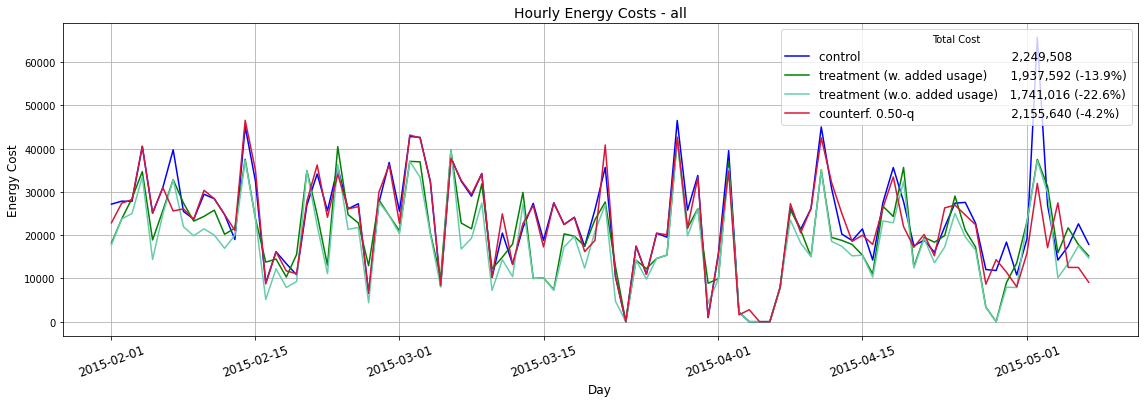

In [29]:
create_counterfactuals.time_series_plot(
    quantile_list = [0.5],
    show_control = True,
    show_treatment_with_usage = True,
    show_treatment_without_usage = True,
    daily_agg = True,
    agg_level = 'all')

Generating forecast for the 0.05-quantile...
Generating forecast for the 0.25-quantile...
Generating forecast for the 0.5-quantile...
Generating forecast for the 0.75-quantile...
Generating forecast for the 0.95-quantile...


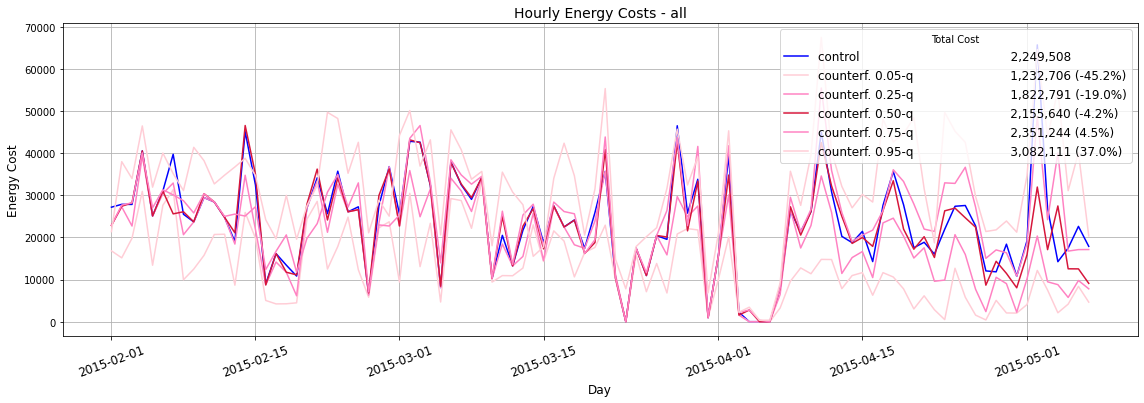

In [30]:
create_counterfactuals.time_series_plot(
    quantile_list = [0.05,0.25,0.5,0.75,0.95],
    show_control = True,
    show_treatment_with_usage = False,
    show_treatment_without_usage = False,
    daily_agg = True,
    agg_level = 'all'
)

# 3. Quantile Distribution

In this section we compute and plot the quantile distributions.

To create the quantile distribution for the treatment and control dataset, we calculate quantiles empirically by ranking the actual data points.

With the DeepAR model, we generate forecasts primarily as binary predictions. We are able to calculate the quantile forecasts directly from the forecast samples. However, the challenge arises when we attempt to convert these binary forecasts into continuous load profiles.

Let's illustrate this challenge using an example. Consider the load profile of a dishwasher in Household 3:

* h1: 148
* h2: 127
* h3: 1
* h4: 1
* h5: 0
* h6: 0

Now, let's generate two binary forecasts, one for the 0.5 quantile and another for the 0.8 quantile:
* 0.5: 0 - 1 - 1 - 0 - 1 - 0
* 0.8: 0 - 1 - 1 - 1 - 1 - 1

When we insert loads from the load profile, here is how it looks:
* 0.5 Quantile Forecast with Loads: 0 - 148 - 127 - 0 - 148 - 0, total usage = 423
* 0.8 Quantile Forecast with Loads: 0 - 148 - 127 - 1 - 1 - 0, total usage = 277

As you can see, the presence of more usage hours in the forecast doesn't necessarily mean higher actual usage and cost. This discrepancy arises because the load profiles are based on historical averages and may not provide realistic load values for extended hours predicted in the forecast. This makes comparing quantiles between forecasted and actual data challenging. Therefore, we choose to compute only empirical quantile functions for counterfactual data to observe the differences effectively. This approach aligns with our goal of evaluating how these differences are distributed and their impact on our analysis.

### 3.1 Initialize the class

We introduce the **'Quantile_Distribution'** class and initialize it with the necessary input parameters.

In [31]:
class Quantile_Distribution:
    '''
    A class for computing and plotting quantile distributions of energy costs in different scenarios
    Parameters:
    ----------
    control
        A dictionary of control dataframes for each device.
    treatment
        A dictionary of treatment dataframes for each device.
    treatment_added_usage
        A dictionary of treatment dataframes with added usage for each device.
    counterfactual
        A dictionary of counterfactual dataframes for each device.
    '''
    def __init__(
        self,
        control,
        treatment,
        treatment_added_usage,
        counterfactual,

    ):
        import numpy as np
        self.control =  {dev: df.copy() for dev, df in control.items()}
        self.treatment = {dev: df.copy() for dev, df in treatment.items()} 
        self.treatment_added_usage = {dev: df.copy() for dev, df in treatment_added_usage.items()} 
        self.counterfactual = {dev: df.copy() for dev, df in counterfactual.items()} 
        self.quantile_range = np.arange(0, 1.01, 0.01)

In [32]:
quantile_distribution = Quantile_Distribution(
    control_aggregations,
    treatment_aggregations,
    treatment_add_usage_aggregations,
    counterfactual_aggregations
)

### 3.2 Calculate empirical quantiles

The **calculate_quantile** method calculates a quantile value from a given dataset data at a specified percentile p by ranking the data. The **calculate_empirical_quantiles** uses this method to calculate a list of empirical quantile values ranging from the 0th percentile to the 100th percentile, in 1 percentile increments.

In [33]:
@staticmethod
def calculate_quantile(data, p):
    import numpy as np

    n = len(data)
    rank = p * (n - 1) 
    floor_rank = np.floor(rank).astype(int)
    ceil_rank = np.ceil(rank).astype(int)
    
    if floor_rank == ceil_rank:
        return data[floor_rank]
    else:
        lower_value = data[floor_rank]
        upper_value = data[ceil_rank]
        weight = rank - floor_rank
        return lower_value + (upper_value - lower_value) * weight
    
setattr(Quantile_Distribution, 'calculate_quantile', calculate_quantile)
del calculate_quantile

In [34]:
def calculate_empirical_quantiles(self, data):
    import numpy as np
    
    quantile_values = []
    for q in self.quantile_range:
        
        sorted_data = np.sort([x for x in data if str(x) != 'nan'])
        quantile_value = self.calculate_quantile(sorted_data, q)
        quantile_values.append(quantile_value)
        
    return quantile_values

setattr(Quantile_Distribution, 'calculate_empirical_quantiles', calculate_empirical_quantiles)
del calculate_empirical_quantiles

### 3.3 Aggregate the quantile distributions

The **calculate_aggregated_quantiles** method computes quantile values aggregated based on the chosen time granularity (daily or hourly) and specified aggregation level. 

In [35]:
def calculate_aggregated_quantiles(self, data_aggregations, daily_agg=True, agg_level=None, is_nonzero = True):
    from copy import deepcopy

    aggregation = f'{"daily" if daily_agg else "hourly"}_{agg_level}'
            
    data_agg = deepcopy(data_aggregations[aggregation])
        
    quantile_values = {}
        
    for ax, item in enumerate(data_agg.keys()):
        if is_nonzero:
            data_agg[item] = data_agg[item]['total_cost'][data_agg[item]['total_cost'] > 0]
        else:
            data_agg[item] = data_agg[item]['total_cost']
        quantile_values[item] = self.calculate_empirical_quantiles(data_agg[item])
        
    return quantile_values
    
setattr(Quantile_Distribution, 'calculate_aggregated_quantiles', calculate_aggregated_quantiles)
del calculate_aggregated_quantiles

### 3.4 Create quantiles 

The **create_quantile_table** method utilizes the **extract_selected_quantiles** function to isolate specific quantile values. It then constructs a pandas DataFrame to display the percentage variances between these quantiles for treatment (with and without added usage) and counterfactual data concerning control data. This table facilitates the comparison of quantile distributions among the different datasets, offering insights into the percentage differences at key percentiles.

In [36]:
@staticmethod
def extract_selected_quantiles(quantile):
    selected_quantiles = []
    quantile_list = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
            
    for index in quantile_list:
        selected_quantiles.append(quantile[index])
            
    return selected_quantiles

setattr(Quantile_Distribution, 'extract_selected_quantiles', extract_selected_quantiles)
del extract_selected_quantiles

In [37]:
def create_quantile_table(self, t_quantile, t_u_quantile, c_quantile, cf_quantile):
    import pandas as pd

    t_quantile_df = pd.DataFrame({'treatment': self.extract_selected_quantiles(t_quantile)})
    t_u_quantile_df = pd.DataFrame({'treatment_with_usage': self.extract_selected_quantiles(t_u_quantile)})
    c_quantile_df = pd.DataFrame({'control': self.extract_selected_quantiles(c_quantile)})
    cf_quantile_df = pd.DataFrame({'counterfactual': self.extract_selected_quantiles(cf_quantile)})

    result_df = pd.concat([c_quantile_df, cf_quantile_df, t_quantile_df, t_u_quantile_df], axis=1).astype(int)
    result_df['counterfactual_diff'] = round(100*(result_df['counterfactual'] - result_df['control']) / result_df['control'], 2)
    result_df['treatment_with_usage_diff'] = round(100*(result_df['treatment_with_usage'] - result_df['control']) / result_df['control'], 2)
    result_df['treatment_diff'] = round(100*(result_df['treatment'] - result_df['control']) / result_df['control'], 2)
    result_df.index = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
    
    result_df = result_df.iloc[:,-3:].T.fillna(0)

    return result_df

setattr(Quantile_Distribution, 'create_quantile_table', create_quantile_table)
del create_quantile_table

In [38]:
def plot_quantile_distributions(self, daily_agg=True, agg_level='all', is_nonzero=False):
    import matplotlib.pyplot as plt
    import numpy as np
    from pandas.plotting import table
        
    treatment_quantile = self.calculate_aggregated_quantiles(self.treatment, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)
    treatment_u_quantile = self.calculate_aggregated_quantiles(self.treatment_added_usage, daily_agg=daily_agg, agg_level=agg_level,  is_nonzero=is_nonzero)
    control_quantile = self.calculate_aggregated_quantiles(self.control, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)
    counterfactual_quantile = self.calculate_aggregated_quantiles(self.counterfactual, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)

    num_cols = 1  # Set the number of columns to 1
    num_rows = len(control_quantile)

    subplot_size = (16, 6)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(subplot_size[0], num_rows * (subplot_size[1]+6)))
            
    if num_rows == 1:
        axes = [axes]
        
    self.quantile_range = np.arange(0, 1.01, 0.01)

    for ax, item in enumerate(control_quantile.keys()):

        # Plotting the quantile distributions
        axes[ax].plot(self.quantile_range, control_quantile[item], linestyle='-', label='control', color='blue')
        axes[ax].plot(self.quantile_range, treatment_u_quantile[item], linestyle='-', label='treatment (w. added usage)', color='green')
        axes[ax].plot(self.quantile_range, treatment_quantile[item], linestyle='-', label='treatment (w.o. added usage)', color='mediumaquamarine')
        axes[ax].plot(self.quantile_range, counterfactual_quantile[item], linestyle='-', label='counterfactual', color='red')
        axes[ax].set_title('Quantile Distribution - {}'.format(item))
        plt.xlabel('Quantiles')
        plt.ylabel('Energy Cost')
        axes[ax].legend(fontsize=11)
        axes[ax].grid()
            
        subax = fig.add_subplot(axes[ax].get_subplotspec(), frame_on=False)

        subax.set_xticks([])
        subax.set_yticks([])
        subax.set_xticklabels([])
        subax.set_yticklabels([])

        plt_dataframe = self.create_quantile_table(treatment_quantile[item],
                                                    treatment_u_quantile[item],
                                                    control_quantile[item], 
                                                    counterfactual_quantile[item])

        tab = table(subax, plt_dataframe,
                    loc='bottom', cellLoc='center', bbox=[0, -0.15, 1, 0.1], edges='horizontal')

        tab.auto_set_font_size(False)
        tab.set_fontsize(12)

    plt.show()

setattr(Quantile_Distribution, 'plot_quantile_distributions', plot_quantile_distributions)
del plot_quantile_distributions


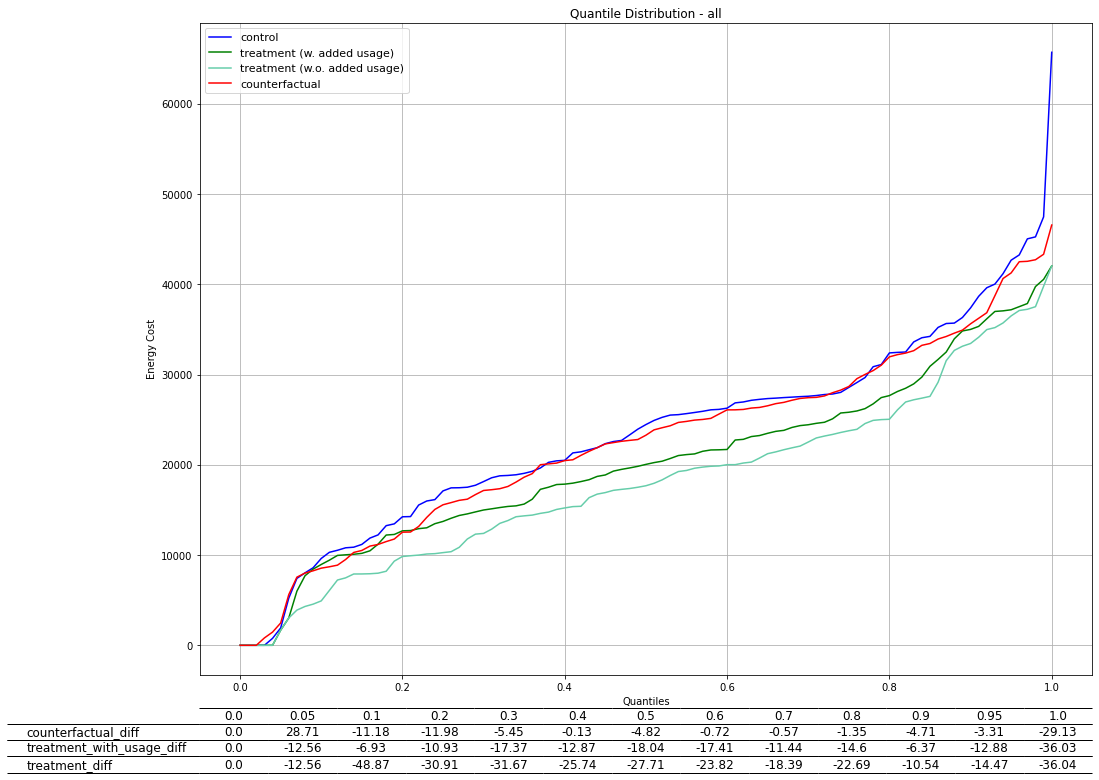

In [39]:
quantile_distribution.plot_quantile_distributions(daily_agg=True, agg_level='all', is_nonzero=False)

## 4. Hypothesis Testing

As a final step, we conduct hypothesis tests to confirm the recommendation system’s impact.

### 4.1 Initialize the class

We introduce the **'Hypothesis_Testing'** class and initialize it with the necessary input parameters.

In [40]:
from typing import Dict, List, Any, Tuple
import pandas as pd
class Hypothesis_Testing:
    '''
    A class for conducting hypothesis testing on cost differences
    Parameters:
    ----------
    control
        A dictionary of control dataframes for each device.
    treatment_usage
        A dictionary of treatment dataframes for each device.
    treatment_added_usage
        A dictionary of treatment dataframes with added usage for each device.
    counterfactual
        A dictionary of counterfactual dataframes for each device.
    '''
    def __init__(
        self,
        control,
        treatment_usage,
        treatment_added_usage,
        counterfactual,

    ):
        import numpy as np
        self.control =  {dev: df.copy() for dev, df in control.items()}
        self.treatment_usage = {dev: df.copy() for dev, df in treatment_usage.items()} 
        self.treatment_added_usage = {dev: df.copy() for dev, df in treatment_added_usage.items()} 
        self.counterfactual = {dev: df.copy() for dev, df in counterfactual.items()} 
        self.quantile_range = np.arange(0, 1.01, 0.01)

In [41]:
hypothesis_testing = Hypothesis_Testing(
    control_aggregations,
    treatment_aggregations,
    treatment_add_usage_aggregations,
    counterfactual_aggregations
)

### 4.2 Compute cost differences

#### *calculate_cost_differences*
This method calculates the true and predicted differences using treatment, counterfactual, and control values and returns them in a dictionary.

In [42]:
@staticmethod
def calculate_cost_differences(treatment_values, cf_values, c_values):
    differences_dict = {}
    differences_dict['true_diff_abs'] = (treatment_values - c_values)
    differences_dict['true_diff_rel'] = ((treatment_values - c_values) / c_values)
    differences_dict['pred_diff_abs'] = (treatment_values - cf_values)
    differences_dict['pred_diff_rel'] = ((treatment_values - cf_values)/ cf_values)
    differences_dict['diff_rel_counterf'] = (cf_values - c_values) / c_values
    return differences_dict
    
setattr(Hypothesis_Testing, 'calculate_cost_differences', calculate_cost_differences)
del calculate_cost_differences

#### *calculate_mean_relative_difference*
This method calculates the mean relative differences.

In [43]:
@staticmethod
def calculate_mean_relative_difference(treatment_values, c_values, cf_values):
    true_diff_rel_mean = (treatment_values.sum() - c_values.sum()) / c_values.sum()
    pred_diff_rel_mean = (treatment_values.sum() - cf_values.sum()) / cf_values.sum()
    return true_diff_rel_mean, pred_diff_rel_mean
    
setattr(Hypothesis_Testing, 'calculate_mean_relative_difference', calculate_mean_relative_difference)
del calculate_mean_relative_difference

#### *replace_nan*
This method replaces infinite or na values with zero in case they emerge due to a division by zero in *calculate_cost_differences* method and it ensures that calculations can proceed without errors.

In [44]:
@staticmethod
def replace_nan(array):
    import numpy as np
    return array.replace([np.inf, -np.inf], np.nan).fillna(0)

setattr(Hypothesis_Testing, 'replace_nan', replace_nan)
del replace_nan

#### *trim_outliers*
This method trims outliers that could arise from division by a small number, such as costs near zero, by excluding the bottom and top 1% of the values.

In [45]:
@staticmethod
def trim_outliers(diff, trim_percent=1):
    import numpy as np
    lower_threshold = np.percentile(diff, trim_percent)
    upper_threshold = np.percentile(diff, 100 - trim_percent)
    trimmed_diff = np.clip(diff, lower_threshold, upper_threshold)
    return trimmed_diff

setattr(Hypothesis_Testing, 'trim_outliers', trim_outliers)
del trim_outliers

#### *create_difference_table*

This method generates a concise table of cost differences at the specified aggregation level, serving as the foundational component for the subsequent hypothesis testing table. The table is instrumental in assessing the statistical significance of the differences.

In [46]:
def create_difference_table(self, agg_level='all', treatment_with_added_usage = False):
    from copy import deepcopy
    import numpy as np
    
    aggregation = f'{"daily"}_{agg_level}'
    
    if treatment_with_added_usage:
        treatment_agg = deepcopy(self.treatment_added_usage[aggregation])
    else:
        treatment_agg = deepcopy(self.treatment_usage[aggregation])
    counterfactual_agg = deepcopy(self.counterfactual[aggregation])
    control_agg = deepcopy(self.control[aggregation])
    
    true_diff_abs= {}
    true_diff_rel= {}
    pred_diff_abs= {}
    pred_diff_rel= {}
    true_diff_rel_mean= {}
    pred_diff_rel_mean= {}
    diff_rel_counterf= {}
    
    for item in control_agg.keys():

        t_values = treatment_agg[item]['total_cost']
        cf_values = counterfactual_agg[item]['total_cost']
        c_values = control_agg[item]['total_cost']
        
        difference_arrays = self.calculate_cost_differences(t_values,cf_values,c_values)
        true_diff_rel_mean[item], pred_diff_rel_mean[item] = self.calculate_mean_relative_difference(t_values, c_values, cf_values)
            
        for key, value in difference_arrays.items():
            difference_arrays[key] = self.replace_nan(value)
            difference_arrays[key] = self.trim_outliers(difference_arrays[key])
    
        true_diff_abs[item] = difference_arrays['true_diff_abs']
        pred_diff_abs[item] = difference_arrays['pred_diff_abs']
        true_diff_rel[item] = difference_arrays['true_diff_rel']
        pred_diff_rel[item] = difference_arrays['pred_diff_rel']
        diff_rel_counterf[item] = difference_arrays['diff_rel_counterf']

    self.rel_diff_true = true_diff_rel
    self.rel_diff_pred = pred_diff_rel
    
    self.rel_diff_counterfactual = diff_rel_counterf
        
    diff_data = {
        'True diff Abs': [int(np.mean(true_diff_abs[item])) for item in control_agg],
        'Pred diff Abs': [int(np.mean(pred_diff_abs[item])) for item in control_agg],
        'True diff Rel': [round(true_diff_rel_mean[item],3) for item in control_agg],
        'Pred diff Rel': [round(pred_diff_rel_mean[item],3) for item in control_agg],
    }

    result_table = pd.DataFrame(diff_data).T
    result_table.columns = [f'{item}' for item in control_agg]
    self.result_table = result_table
    
setattr(Hypothesis_Testing, 'create_difference_table', create_difference_table)
del create_difference_table

### 4.3 Plot relative changes in cost

The **plot_cost_changes** method generates plots to visually depict the relative changes in cost over time. It plots three series on which we base our hypothesis tests: true relative change, predicted relative change, and relative forecast error. 

In [47]:
def plot_cost_changes(self):
    import numpy as np
    import matplotlib.pyplot as plt 
    
    num_cols = 1
    num_rows = len(self.rel_diff_true)

    subplot_size = (10, 6)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(subplot_size[0], num_rows * subplot_size[1]))
    
    if num_rows == 1:
        axes = [axes]
        
    for ax, item in enumerate(self.rel_diff_true.keys()):

        axes[ax].plot(self.rel_diff_true[item],label='true relative difference,     mean={}'.format(round(np.mean(self.rel_diff_true[item]),2)),color='green')
        axes[ax].plot(self.rel_diff_pred[item],label='pred relative difference,    mean={}'.format(round(np.mean(self.rel_diff_pred[item]),2)),color='lightgreen')
        axes[ax].plot(self.rel_diff_counterfactual[item],label='relative forecast error,       mean={}'.format(round(np.mean(self.rel_diff_counterfactual[item]),2)),color='red')
        axes[ax].axhline(0, color='black', linestyle='--')
        axes[ax].legend()
        
        axes[ax].set_title('Relative Difference to Control Set - {}'.format(item))
        plt.xlabel('Day')
        plt.ylabel('Daily Change in %')
        axes[ax].legend(fontsize=11)
        axes[ax].grid()

setattr(Hypothesis_Testing, 'plot_cost_changes', plot_cost_changes)
del plot_cost_changes

In [48]:
hypothesis_testing.create_difference_table(agg_level='all', treatment_with_added_usage = False)

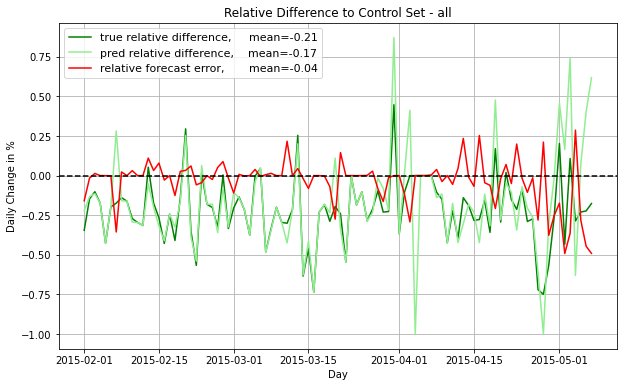

In [49]:
hypothesis_testing.plot_cost_changes()

We check if the data is normally distributed using the Shapiro-Wilk test

### 4.4 Hypothesis testing

#### *check_normality*

This method tests if the relative changes we compute are normally distributed, and it helps us choose between a t-test and Wilcoxon test.

In [50]:
@staticmethod
def check_normality(data, alpha=0.05):
    import scipy.stats as st
    
    return st.shapiro(data).pvalue

setattr(Hypothesis_Testing, 'check_normality', check_normality)
del check_normality

#### *perform_significance_test*

This method conducts a statistical significance test between two datasets, data1 and, optionally, data2. After assessesing the normality of the data it conducts a t-test or a Wilcoxon test and returns the p-value as the outcome.

In [51]:
def perform_significance_test(self, data1, data2=None, alpha=0.05):
    import scipy.stats as st
    import numpy as np
    
    if (data1 == 0).all():
        # "No change in treatment, skip"
        return np.nan
    
    is_data1_normal = self.check_normality(data1)
    
    if data2 is None:
        if is_data1_normal > alpha:
            # Data1 is normally distributed, perform a t-test
            _, p_value = st.ttest_ind(data1, np.zeros_like(data1))
        else:
            # Data1 is not normally distributed, perform a Wilcoxon test
            _, p_value = st.wilcoxon(data1)
    else:
        is_data2_normal = self.check_normality(data2)
        
        if is_data1_normal > alpha and is_data2_normal > alpha:
            # Both data1 and data2 are normally distributed, perform a t-test
            _, p_value = st.ttest_ind(data1, data2)
        else:
            # Either data1 or data2 (or both) is not normally distributed, perform a Wilcoxon test
            _, p_value = st.wilcoxon(data1, data2)
    
    p_value = round(p_value, 3)
    
    return p_value

setattr(Hypothesis_Testing, 'perform_significance_test', perform_significance_test)
del perform_significance_test

#### *perform_hypothesis_test*

This method determines if the difference in relative cost change is significant based on the results of the hypothesis tests and the given significance level alpha. It then combines these p-values with the existing result table, and returns a compact summary that helps identify significant impacts.

In [52]:
def perform_hypothesis_test(self, alpha=0.05):
    import numpy as np
    
    p_rel_diff_true = {}
    p_rel_diff_pred = {}
    p_rel_diff_counterfactual = {}
    
    for key in self.rel_diff_true.keys():
        
        p_rel_diff_true[key] = self.perform_significance_test(self.rel_diff_true[key], data2=None, alpha=0.05)
        p_rel_diff_pred[key] = self.perform_significance_test(self.rel_diff_pred[key], data2=None, alpha=0.05)
        p_rel_diff_counterfactual[key] = self.perform_significance_test(self.rel_diff_pred[key], data2=self.rel_diff_counterfactual[key], alpha=0.05)
    
    result_table_complete = self.result_table.copy().T
    result_table_complete['True H(1) p-value'] = p_rel_diff_true.values()
    result_table_complete['Pred H(1) p-value'] = p_rel_diff_pred.values()
    result_table_complete['Pred H(2) p-value'] = p_rel_diff_counterfactual.values()
    
    result_table_complete['True Significant'] = np.where(
        (result_table_complete['True H(1) p-value']<= alpha)&(result_table_complete['True diff Abs']<0),
        u'\N{check mark}', 'x')    
    result_table_complete['Pred Significant'] = np.where(
        (result_table_complete['Pred H(1) p-value']<= alpha)&(result_table_complete['Pred H(2) p-value']<= alpha)&(result_table_complete['Pred diff Abs']<0)
        , u'\N{check mark}', 'x')    
        
    return result_table_complete.T
    
setattr(Hypothesis_Testing, 'perform_hypothesis_test', perform_hypothesis_test)
del perform_hypothesis_test
        

In [53]:
hypothesis_testing.perform_hypothesis_test()

,all
True diff Abs,-5239.0
Pred diff Abs,-4311.0
True diff Rel,-0.226
Pred diff Rel,-0.192
True H(1) p-value,0.0
Pred H(1) p-value,0.0
Pred H(2) p-value,0.0
True Significant,✓
Pred Significant,✓


### 4.5 Pipeline

In [54]:
def pipeline(self, agg_level='all', treatment_with_added_usage = False, alpha=0.05, plot_changes = False):
    
    self.create_difference_table(agg_level=agg_level,
                                 treatment_with_added_usage = treatment_with_added_usage)
    
    if plot_changes:
        self.plot_cost_changes()
    
    print(self.perform_hypothesis_test(alpha))
    
setattr(Hypothesis_Testing, 'pipeline', pipeline)
del pipeline
        

In [55]:
hypothesis_testing.pipeline(agg_level='all', treatment_with_added_usage = False, plot_changes = False)

                      all
True diff Abs     -5239.0
Pred diff Abs     -4311.0
True diff Rel      -0.226
Pred diff Rel      -0.192
True H(1) p-value     0.0
Pred H(1) p-value     0.0
Pred H(2) p-value     0.0
True Significant        ✓
Pred Significant        ✓


<br>
<br>
<br>

## **Appendix A1: Complete Create_Counterfactual_Time_Series Class**

In [56]:

class Create_Counterfactual_Time_Series:
    '''
    A class for generating counterfactual load usage patterns from binary forecasts
    Parameters:
    ----------
    forecast
        A dictionary of forecasted dataframes for each device
    forecast_samples
        A Forecast object, where the predicted distribution is represented internally as samples
    target
        A dictionary of target dataframes for each device
    devices
        A dictionary containing device-specific information
    price_df
         A DataFrame with hourly price data in GBP per megawatt-hour.
    '''
    def __init__(
        self,
        forecast_samples,
        forecast: Dict[str, pd.DataFrame],
        target: Dict[str, pd.DataFrame],
        devices: Dict[str, Any],
        price_df: pd.DataFrame,

    ):
        import numpy as np
        self.forecast_samples = forecast_samples
        self.forecast =  {dev: df.copy() for dev, df in forecast.items()}
        self.target = {dev: df.copy() for dev, df in target.items()} 
        self.devices = devices
        self.date_list = np.unique(next(iter(self.forecast.values())).index.date)
        self.price_df = price_df
        
    def _calculate_usage_length(self, data, start_dataset):
        import pandas as pd
        return (
            ((data.iloc[start_dataset:] == 0).idxmax() - data.index[start_dataset])
                // pd.Timedelta(minutes=60)
            )[0]

    def _insert_usage_values_from_target(
    self,
    daily_forecast_extended,
    daily_target_extended,
    start_hours_forecast,
    target_start_hour,
    load_profile,
):
        import pandas as pd
            
        nearest_forecast_start_hour = min(
            start_hours_forecast, key=lambda x: abs(x - target_start_hour)
        )

        time_shift = nearest_forecast_start_hour - target_start_hour

        usage_length_target = self._calculate_usage_length(
            daily_target_extended, target_start_hour
        )
        usage_length_forecast = self._calculate_usage_length(
            daily_forecast_extended, nearest_forecast_start_hour
        )
        
        usage_length_forecast = min(usage_length_forecast,24)

        target_hours_pre_shift = daily_target_extended.iloc[
            target_start_hour:target_start_hour + usage_length_forecast
        ]
        
        target_hours_post_shift = target_hours_pre_shift.shift(periods=time_shift, freq="60T")
        if usage_length_forecast > usage_length_target:

            target_hours_post_shift.iloc[
                usage_length_target: min(usage_length_forecast,len(target_hours_post_shift)),0
            ] = load_profile[usage_length_target:min(usage_length_forecast,len(target_hours_post_shift))]
        
        daily_forecast_extended.iloc[
            nearest_forecast_start_hour:nearest_forecast_start_hour
            + usage_length_forecast
        ] = 0
        daily_forecast_extended = target_hours_post_shift.combine_first(
            daily_forecast_extended
        )

        start_hours_forecast.remove(nearest_forecast_start_hour)
        
        return daily_forecast_extended, start_hours_forecast

    def _insert_usage_values_from_load_profile(
    self,
    load_profile,
    daily_forecast_extended,
    forecast_start_dataset,
):
        usage_length_forecast = self._calculate_usage_length(
            daily_forecast_extended, forecast_start_dataset
        )
        
        daily_forecast_extended.iloc[
            forecast_start_dataset:forecast_start_dataset
            + usage_length_forecast,
            0,
        ] = load_profile[0:usage_length_forecast]
            
        return daily_forecast_extended

    def create_counterfactual_time_series(self, is_info_displayed=False):
        from datetime import timedelta
        import pandas as pd
        
        results = {}
        
        # Iterate through each device
        for dev in self.devices.keys():
            forecast = self.forecast[dev].copy()
            target = self.target[dev]
            load_profile = self.devices[dev]['load_profile']
            
            # Initialize an output DataFrame
            output = pd.DataFrame(index=forecast.index, columns=['usage'])
            
            if is_info_displayed:
                print('\n', 'device nr: ', dev)
            
            # Iterate over each date in the specified date list
            for date in self.date_list:
                date_before = date - timedelta(days=1)
                date = str(date)

                # Extract daily forecast and target data
                daily_forecast = forecast.loc[date]
                daily_target = target.loc[date]

                daily_target_extended = target.loc[date:][:48]
                daily_forecast_extended = forecast.loc[date:][:48]

                # Check if there is device usage on the forecast day
                if daily_forecast.values.sum() == 0:
                    if is_info_displayed:
                        print(date, "no device usage forecasted")
                    continue

                # Create shifted versions of daily forecast and target to calculate start hours
                shifted_daily_forecast = daily_forecast.shift()
                shifted_daily_target = daily_target.shift()
                    
                if date != str(self.date_list[0]):
                    shifted_daily_forecast.iloc[0] = forecast.loc[str(date_before)].iloc[-1]
                    shifted_daily_target.iloc[0] = target.loc[str(date_before)].iloc[-1]
                    
                start_hours_forecast = daily_forecast[
                    (daily_forecast.values == 1) & (shifted_daily_forecast.values == 0)
                ].index.hour.tolist()

                # Continue only if there is usage start on the forecast day
                if start_hours_forecast == []:
                    continue

                # Identify the start hours for device usage in target
                start_hours_target = daily_target[
                    (daily_target.values > 0) & (shifted_daily_target.values == 0)
                ].index.hour.tolist()

                # Sort target start hours based on proximity to forecast start hours
                sorted_start_hours_target = sorted(
                    start_hours_target,
                    key=lambda x: min(abs(x - r) for r in start_hours_forecast),
                )
                
                if is_info_displayed:
                    if len(start_hours_target) > len(start_hours_forecast):
                        print(date, 'More device start hours than forecasted')
                    else:
                        print(date, 'Less than or equal device start hours than forecasted')
                        
                # Iterate through sorted target start hours
                for target_start_hour in sorted_start_hours_target:
                    if start_hours_forecast == []:
                        break
                    
                    # Insert target usage values into forecast
                    daily_forecast_extended, start_hours_forecast = self._insert_usage_values_from_target(
                        daily_forecast_extended,
                        daily_target_extended,
                        start_hours_forecast,
                        target_start_hour,
                        load_profile,
                    )

                # Handle remaining start hours by inserting load profile data
                for forecast_start_dataset in start_hours_forecast:
                    if daily_forecast_extended['usage'].iloc[forecast_start_dataset] <= 1:
                        daily_forecast_extended = self._insert_usage_values_from_load_profile(
                            load_profile,
                            daily_forecast_extended,
                            forecast_start_dataset,
                        )
                        
                # Combine daily adjusted usage values into the output DataFrame
                output = daily_forecast_extended[daily_forecast_extended['usage'] > 1].combine_first(output)
                    
            results[dev] = output.fillna(0)

        return results

    def calculate_total_cost(self, usage_df):
        import pandas as pd
        usage_df = pd.DataFrame(usage_df)
        usage_df = usage_df.join(self.price_df, how="inner")
        usage_df["total_cost"] = usage_df["usage"] * usage_df["Price"]

        return usage_df

    def agg_to_day_level(self, time_series):
        import pandas as pd
        agg_time_series = {}
        for i in time_series.keys():
            agg_time_series[i] = 0
            agg_time_series[i] = time_series[i].groupby(pd.Grouper(freq='D')).sum()

        return agg_time_series

    def agg_to_dev_level(self, time_series):
        import numpy as np
        agg_time_series = {}
        count_per_dev = {}

        for dev in np.unique([self.devices[x]["dev"] for x in self.devices.keys()]):
            agg_time_series[dev] = 0
            count_per_dev[dev] = 0

            for i in [x for x in self.devices.keys() if self.devices[x]["dev"] == dev]:
                agg_time_series[dev] += time_series[i]
                count_per_dev[dev] += 1  # Increment the count for this device

            agg_time_series[dev] /= count_per_dev[dev]

        return agg_time_series

    def agg_to_hh_level(self, time_series):
        import numpy as np
        agg_time_series = {}
        count_per_hh = {}
        for hh in np.unique([self.devices[x]["hh"] for x in self.devices.keys()]):
            agg_time_series[hh] = 0
            count_per_hh[hh] = 0

            for i in [x for x in self.devices.keys() if self.devices[x]["hh"] == hh]:
                agg_time_series[hh] += time_series[i]
                count_per_hh[hh] += 1
            
            agg_time_series[hh] /= count_per_hh[hh]

        return agg_time_series

    def agg_complete(self, time_series):

        agg_time_series = list(time_series.values())[0].copy()
        agg_time_series = agg_time_series*0

        for dev in self.devices.keys():
            agg_time_series += time_series[dev].copy()

        agg_time_series_dict = {}
        agg_time_series_dict["all"] = agg_time_series / len(self.devices)
        return agg_time_series_dict 

    def pipeline(self,is_info_displayed=False,daily_agg=True,agg_level=None):

        counterfactual_usage = self.create_counterfactual_time_series(is_info_displayed)
        
        counterfactual_cost = {}
        for dev in self.devices.keys():
            counterfactual_cost[dev] = self.calculate_total_cost(counterfactual_usage[dev])

        if agg_level == "dev":
            counterfactual_output = self.agg_to_dev_level(counterfactual_cost)
        elif agg_level == "hh":
            counterfactual_output = self.agg_to_hh_level(counterfactual_cost)
        elif agg_level == "all":
            counterfactual_output = self.agg_complete(counterfactual_cost)
        elif agg_level is None:
            counterfactual_output = counterfactual_cost
        else:
            raise ValueError("Invalid aggregation option. Please choose from 'dev', 'hh', 'all', or None.")
                
        if daily_agg:
            counterfactual_output = self.agg_to_day_level(counterfactual_output)
                
        return counterfactual_output

    def generate_aggregated_counterfactuals(self):
        scenarios = {}
        
        agg_levels = ['hh', 'dev', 'all', None]
        daily_agg_options = [True, False]
        
        for agg_level in agg_levels:
            for daily_agg in daily_agg_options:
                
                scenario_key = f'{"daily" if daily_agg else "hourly"}_{agg_level}'
                
                scenarios[scenario_key] = self.pipeline(
                    is_info_displayed=False, daily_agg=daily_agg, agg_level=agg_level
                )
        
        return scenarios

    def generate_aggregated_loads(self, loads):
        from copy import deepcopy
    
        scenarios = {}
        
        aggregated_loads = deepcopy(loads)
        
        for i in self.devices.keys():  
            aggregated_loads[i] = self.calculate_total_cost(aggregated_loads[i])
        
        scenarios = {}
        
        scenarios['hourly_None'] = aggregated_loads
        scenarios['hourly_dev'] = self.agg_to_dev_level(aggregated_loads)
        scenarios['hourly_hh'] = self.agg_to_hh_level(aggregated_loads)
        scenarios['hourly_all'] = self.agg_complete(aggregated_loads)
        
        scenarios['daily_None'] = self.agg_to_day_level(scenarios['hourly_None'])
        scenarios['daily_dev'] = self.agg_to_day_level(scenarios['hourly_dev'])
        scenarios['daily_hh'] = self.agg_to_day_level(scenarios['hourly_hh'])
        scenarios['daily_all'] = self.agg_to_day_level(scenarios['hourly_all'])
        
        return scenarios

    def time_series_plot(self, quantile_list, show_control=False, show_treatment_with_usage=False, show_treatment_without_usage=True, daily_agg=True, agg_level=None):
        from matplotlib import pyplot as plt
        from matplotlib.colors import LinearSegmentedColormap
        from Thesis_Classes import Generate_Forecasts

        cmap = LinearSegmentedColormap.from_list('CustomGradient', ['#ffdfdb', '#ff82c4', '#d6163b'])

        aggregation = f'{"daily" if daily_agg else "hourly"}_{agg_level}'

        forecast_quantile_list = {}

        for q in quantile_list:
            print('Generating forecast for the {}-quantile...'.format(q))
            
            forecast_quantile = Generate_Forecasts.create_forecast_quantiles(self.forecast_samples, quantile=q)
            create_counterfactuals = Create_Counterfactual_Time_Series(self.forecast_samples, forecast_quantile, self.target, self.devices, self.price_df)
            forecast_quantile_list[q] = create_counterfactuals.pipeline(
                is_info_displayed=False, daily_agg=daily_agg, agg_level=agg_level
            )

        for item, values in forecast_quantile_list[q].items():
            width = 16
            height = 5.71

            plt.figure(figsize=(width, height))

            if show_control:
                control_costs = int(self.control_aggregations[aggregation][item]['total_cost'].sum())

                plt.plot(
                    self.control_aggregations[aggregation][item]['total_cost'],
                    label=f"control                                       {control_costs:,}",
                    color='blue'
                )
            
            if show_treatment_with_usage:
                treatment = self.treatment_add_usage_aggregations
                treatment_costs = int(treatment[aggregation][item]['total_cost'].sum())
                        
                if show_control:
                    # Calculate relative cost difference between treatment and control
                    relative_cost_diff_treatment = (treatment_costs - control_costs) / control_costs
                    treatment_label = f"treatment (w. added usage)      {treatment_costs:,} ({relative_cost_diff_treatment:.1%})"
                else:
                    treatment_label = f"treatment (w. added usage)      {treatment_costs:,}"
                        
                plt.plot(
                    treatment[aggregation][item]['total_cost'],
                    label=treatment_label,
                    color='green'
                )
                        
            if show_treatment_without_usage:
                treatment = self.treatment_aggregations
                treatment_costs = int(treatment[aggregation][item]['total_cost'].sum())
                        
                if show_control:
                    # Calculate relative cost difference between treatment and control
                    relative_cost_diff_treatment = (treatment_costs - control_costs) / control_costs
                    treatment_label = f"treatment (w.o. added usage)   {treatment_costs:,} ({relative_cost_diff_treatment:.1%})"
                else:
                    treatment_label = f"treatment (w.o. added usage)   {treatment_costs:,}"
                        
                plt.plot(
                    treatment[aggregation][item]['total_cost'],
                    label=treatment_label,
                    color='mediumaquamarine'
                )
            for q in quantile_list:
                color = cmap((1 - q) * 2) if q > 0.5 else cmap(q * 2)
                counterf_costs = int(forecast_quantile_list[q][item]['total_cost'].sum())
                
                if show_control:
                    # Calculate relative cost difference between counterfactual and control
                    relative_cost_diff_counterfactual = (counterf_costs - control_costs) / control_costs
                    counterfactual_label = f"counterf. {q:.2f}-q                         {counterf_costs:,} ({relative_cost_diff_counterfactual:.1%})"
                else:
                    counterfactual_label = f"counterf. {q:.2f}-q                         {counterf_costs:,}"

                plt.plot(
                    forecast_quantile_list[q][item]['total_cost'],
                    label=counterfactual_label,
                    color=color
                )

            plt.title('Hourly Energy Costs - {}'.format(item), fontsize=14)
            plt.xlabel('Day', fontsize=12)
            plt.ylabel('Energy Cost', fontsize=12)
            plt.grid()
            plt.legend(loc=1, title='Total Cost', fontsize=12)
            plt.xticks(rotation=20, fontsize=12)
            plt.tight_layout()
            plt.show()


## **Appendix A2: Complete Quantile_Distribution Class**

In [57]:

class Quantile_Distribution:
    '''
    A class for computing and plotting quantile distributions of energy costs in different scenarios
    Parameters:
    ----------
    control
        A dictionary of control dataframes for each device.
    treatment
        A dictionary of treatment dataframes for each device.
    treatment_added_usage
        A dictionary of treatment dataframes with added usage for each device.
    counterfactual
        A dictionary of counterfactual dataframes for each device.
    '''
    def __init__(
        self,
        control,
        treatment,
        treatment_added_usage,
        counterfactual,

    ):
        import numpy as np
        self.control =  {dev: df.copy() for dev, df in control.items()}
        self.treatment = {dev: df.copy() for dev, df in treatment.items()} 
        self.treatment_added_usage = {dev: df.copy() for dev, df in treatment_added_usage.items()} 
        self.counterfactual = {dev: df.copy() for dev, df in counterfactual.items()} 
        self.quantile_range = np.arange(0, 1.01, 0.01)
    
    @staticmethod
    def calculate_quantile(data, p):
        import numpy as np

        n = len(data)
        rank = p * (n - 1) 
        floor_rank = np.floor(rank).astype(int)
        ceil_rank = np.ceil(rank).astype(int)
        
        if floor_rank == ceil_rank:
            return data[floor_rank]
        else:
            lower_value = data[floor_rank]
            upper_value = data[ceil_rank]
            weight = rank - floor_rank
            return lower_value + (upper_value - lower_value) * weight
        
    def calculate_empirical_quantiles(self, data):
        import numpy as np
        
        quantile_values = []
        for q in self.quantile_range:
            
            sorted_data = np.sort([x for x in data if str(x) != 'nan'])
            quantile_value = self.calculate_quantile(sorted_data, q)
            quantile_values.append(quantile_value)
            
        return quantile_values
    
    def calculate_aggregated_quantiles(self, data_aggregations,daily_agg=True, agg_level=None, is_nonzero = True):
        from copy import deepcopy

        aggregation = f'{"daily" if daily_agg else "hourly"}_{agg_level}'
                
        data_agg = deepcopy(data_aggregations[aggregation])
            
        quantile_values = {}
            
        for ax, item in enumerate(data_agg.keys()):
            if is_nonzero:
                data_agg[item] = data_agg[item]['total_cost'][data_agg[item]['total_cost'] > 0]
            else:
                data_agg[item] = data_agg[item]['total_cost']
            quantile_values[item] = self.calculate_empirical_quantiles(data_agg[item])
            
        return quantile_values
    
    @staticmethod
    def extract_selected_quantiles(quantile):
        selected_quantiles = []
        quantile_list = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
            
        for index in quantile_list: 
            selected_quantiles.append(quantile[index])
            
        return selected_quantiles
    
    def create_quantile_table(self, t_quantile, t_u_quantile, c_quantile, cf_quantile):
        import pandas as pd

        t_quantile_df = pd.DataFrame({'treatment': self.extract_selected_quantiles(t_quantile)})
        t_u_quantile_df = pd.DataFrame({'treatment_with_usage': self.extract_selected_quantiles(t_u_quantile)})
        c_quantile_df = pd.DataFrame({'control': self.extract_selected_quantiles(c_quantile)})
        cf_quantile_df = pd.DataFrame({'counterfactual': self.extract_selected_quantiles(cf_quantile)})

        result_df = pd.concat([c_quantile_df, cf_quantile_df, t_quantile_df, t_u_quantile_df], axis=1).astype(int)
        result_df['counterfactual_diff'] = round(100*(result_df['counterfactual'] - result_df['control']) / result_df['control'], 2)
        result_df['treatment_with_usage_diff'] = round(100*(result_df['treatment_with_usage'] - result_df['control']) / result_df['control'], 2)
        result_df['treatment_diff'] = round(100*(result_df['treatment'] - result_df['control']) / result_df['control'], 2)
        result_df.index = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
        
        result_df = result_df.iloc[:,-3:].T.fillna(0)

        return result_df
    
    def plot_quantile_distributions(self, daily_agg=True, agg_level='all', is_nonzero=False):
        import matplotlib.pyplot as plt
        import numpy as np
        from pandas.plotting import table
        
        treatment_quantile = self.calculate_aggregated_quantiles(self.treatment, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)
        treatment_u_quantile = self.calculate_aggregated_quantiles(self.treatment_added_usage, daily_agg=daily_agg, agg_level=agg_level,  is_nonzero=is_nonzero)
        control_quantile = self.calculate_aggregated_quantiles(self.control, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)
        counterfactual_quantile = self.calculate_aggregated_quantiles(self.counterfactual, daily_agg=daily_agg, agg_level=agg_level, is_nonzero=is_nonzero)

        num_cols = 1  # Set the number of columns to 1
        num_rows = len(control_quantile)

        subplot_size = (16, 6)
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(subplot_size[0], num_rows * (subplot_size[1]+6)))
        
        if num_rows == 1:
            axes = [axes]
        
        self.quantile_range = np.arange(0, 1.01, 0.01)

        for ax, item in enumerate(control_quantile.keys()):

            # Plotting the quantile distributions
            axes[ax].plot(self.quantile_range, control_quantile[item], linestyle='-', label='control', color='blue')
            axes[ax].plot(self.quantile_range, treatment_u_quantile[item], linestyle='-', label='treatment (w. added usage)', color='green')
            axes[ax].plot(self.quantile_range, treatment_quantile[item], linestyle='-', label='treatment (w.o. added usage)', color='mediumaquamarine')
            axes[ax].plot(self.quantile_range, counterfactual_quantile[item], linestyle='-', label='counterfactual', color='red')
            axes[ax].set_title('Quantile Distribution - {}'.format(item))
            plt.xlabel('Quantiles')
            plt.ylabel('Energy Cost')
            axes[ax].legend(fontsize=11)
            axes[ax].grid()
            
            # Creating a subplot within the current axes for the table
            subax = fig.add_subplot(axes[ax].get_subplotspec(), frame_on=False)

            subax.set_xticks([])
            subax.set_yticks([])
            subax.set_xticklabels([])
            subax.set_yticklabels([])

            plt_dataframe = self.create_quantile_table(treatment_quantile[item],
                                                    treatment_u_quantile[item],
                                                    control_quantile[item], 
                                                    counterfactual_quantile[item])

            tab = table(subax, plt_dataframe,
                        loc='bottom', cellLoc='center', bbox=[0, -0.15, 1, 0.1], edges='horizontal')

            tab.auto_set_font_size(False)
            tab.set_fontsize(12)

        plt.show()


## **Appendix A3: Complete Hypothesis_Testing Class**

In [58]:

class Hypothesis_Testing:
    '''
    A class for conducting hypothesis testing on cost differences
    Parameters:
    ----------
    control
        A dictionary of control dataframes for each device.
    treatment_usage
        A dictionary of treatment dataframes for each device.
    treatment_added_usage
        A dictionary of treatment dataframes with added usage for each device.
    counterfactual
        A dictionary of counterfactual dataframes for each device.
    '''
    def __init__(
        self,
        control,
        treatment_usage,
        treatment_added_usage,
        counterfactual,

    ):
        import numpy as np
        self.control =  {dev: df.copy() for dev, df in control.items()}
        self.treatment_usage = {dev: df.copy() for dev, df in treatment_usage.items()} 
        self.treatment_added_usage = {dev: df.copy() for dev, df in treatment_added_usage.items()} 
        self.counterfactual = {dev: df.copy() for dev, df in counterfactual.items()} 
        self.quantile_range = np.arange(0, 1.01, 0.01)

    @staticmethod
    def calculate_cost_differences(treatment_values, cf_values, c_values):
        differences_dict = {}
        differences_dict['true_diff_abs'] = (treatment_values - c_values)
        differences_dict['true_diff_rel'] = ((treatment_values - c_values) / c_values)
        differences_dict['pred_diff_abs'] = (treatment_values - cf_values)
        differences_dict['pred_diff_rel'] = ((treatment_values - cf_values)/ cf_values)
        differences_dict['diff_rel_counterf'] = (cf_values - c_values) / c_values
        return differences_dict
        
    @staticmethod
    def calculate_mean_relative_difference(treatment_values, c_values, cf_values):
        true_diff_rel_mean = (treatment_values.sum() - c_values.sum()) / c_values.sum()
        pred_diff_rel_mean = (treatment_values.sum() - cf_values.sum()) / cf_values.sum()
        return true_diff_rel_mean, pred_diff_rel_mean
        
    @staticmethod
    def replace_nan(array):
        import numpy as np
        return array.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    @staticmethod
    def trim_outliers(diff, trim_percent=1):
        import numpy as np
        lower_threshold = np.percentile(diff, trim_percent)
        upper_threshold = np.percentile(diff, 100 - trim_percent)
        trimmed_diff = np.clip(diff, lower_threshold, upper_threshold)
        return trimmed_diff

    def create_difference_table(self, agg_level='all', treatment_with_added_usage = False):
        from copy import deepcopy
        import numpy as np
        
        aggregation = f'{"daily"}_{agg_level}'
        
        if treatment_with_added_usage:
            treatment_agg = deepcopy(self.treatment_added_usage[aggregation])
        else:
            treatment_agg = deepcopy(self.treatment_usage[aggregation])
        counterfactual_agg = deepcopy(self.counterfactual[aggregation])
        control_agg = deepcopy(self.control[aggregation])
        
        true_diff_abs= {}
        true_diff_rel= {}
        pred_diff_abs= {}
        pred_diff_rel= {}
        true_diff_rel_mean= {}
        pred_diff_rel_mean= {}
        diff_rel_counterf= {}
        
        for item in control_agg.keys():

            t_values = treatment_agg[item]['total_cost']
            cf_values = counterfactual_agg[item]['total_cost']
            c_values = control_agg[item]['total_cost']
            
            difference_arrays = self.calculate_cost_differences(t_values,cf_values,c_values)
            true_diff_rel_mean[item], pred_diff_rel_mean[item] = self.calculate_mean_relative_difference(t_values, c_values, cf_values)
                
            for key, value in difference_arrays.items():
                difference_arrays[key] = self.replace_nan(value)
                difference_arrays[key] = self.trim_outliers(difference_arrays[key])
        
            true_diff_abs[item] = difference_arrays['true_diff_abs']
            pred_diff_abs[item] = difference_arrays['pred_diff_abs']
            true_diff_rel[item] = difference_arrays['true_diff_rel']
            pred_diff_rel[item] = difference_arrays['pred_diff_rel']
            diff_rel_counterf[item] = difference_arrays['diff_rel_counterf']

        self.rel_diff_true = true_diff_rel
        self.rel_diff_pred = pred_diff_rel
        
        self.rel_diff_counterfactual = diff_rel_counterf
            
        diff_data = {
            'True diff Abs': [int(np.mean(true_diff_abs[item])) for item in control_agg],
            'Pred diff Abs': [int(np.mean(pred_diff_abs[item])) for item in control_agg],
            'True diff Rel': [round(true_diff_rel_mean[item],3) for item in control_agg],
            'Pred diff Rel': [round(pred_diff_rel_mean[item],3) for item in control_agg],
        }

        result_table = pd.DataFrame(diff_data).T
        result_table.columns = [f'{item}' for item in control_agg]
        self.result_table = result_table
        
    def plot_cost_changes(self):
        import numpy as np
        import matplotlib.pyplot as plt 
        
        num_cols = 1
        num_rows = len(self.rel_diff_true)

        subplot_size = (10, 6)
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(subplot_size[0], num_rows * subplot_size[1]))
        
        if num_rows == 1:
            axes = [axes]
            
        for ax, item in enumerate(self.rel_diff_true.keys()):

            axes[ax].plot(self.rel_diff_true[item],label='true relative difference,     mean={}'.format(round(np.mean(self.rel_diff_true[item]),2)),color='green')
            axes[ax].plot(self.rel_diff_pred[item],label='pred relative difference,    mean={}'.format(round(np.mean(self.rel_diff_pred[item]),2)),color='lightgreen')
            axes[ax].plot(self.rel_diff_counterfactual[item],label='relative forecast error,       mean={}'.format(round(np.mean(self.rel_diff_counterfactual[item]),2)),color='red')
            axes[ax].axhline(0, color='black', linestyle='--')
            axes[ax].legend()
            
            axes[ax].set_title('Relative Difference to Control Set - {}'.format(item))
            plt.xlabel('Day')
            plt.ylabel('Daily Change in %')
            axes[ax].legend(fontsize=11)
            axes[ax].grid()

    @staticmethod
    def check_normality(data, alpha=0.05):
        import scipy.stats as st
        
        return st.shapiro(data).pvalue
    
    def perform_significance_test(self, data1, data2=None, alpha=0.05):
        import scipy.stats as st
        import numpy as np
        
        if (data1 == 0).all():
            # "No change in treatment, skip"
            return np.nan
        
        is_data1_normal = self.check_normality(data1)
        
        if data2 is None:
            if is_data1_normal > alpha:
                # Data1 is normally distributed, perform a t-test
                _, p_value = st.ttest_ind(data1, np.zeros_like(data1))
            else:
                # Data1 is not normally distributed, perform a Wilcoxon test
                _, p_value = st.wilcoxon(data1)
        else:
            is_data2_normal = self.check_normality(data2)
            
            if is_data1_normal > alpha and is_data2_normal > alpha:
                # Both data1 and data2 are normally distributed, perform a t-test
                _, p_value = st.ttest_ind(data1, data2)
            else:
                # Either data1 or data2 (or both) is not normally distributed, perform a Wilcoxon test
                _, p_value = st.wilcoxon(data1, data2)
        
        p_value = round(p_value, 3)
        
        return p_value
    
    def perform_hypothesis_test(self, alpha=0.05):
        import numpy as np
        
        p_rel_diff_true = {}
        p_rel_diff_pred = {}
        p_rel_diff_counterfactual = {}
        
        for key in self.rel_diff_true.keys():
            
            p_rel_diff_true[key] = self.perform_significance_test(self.rel_diff_true[key], data2=None, alpha=0.05)
            p_rel_diff_pred[key] = self.perform_significance_test(self.rel_diff_pred[key], data2=None, alpha=0.05)
            p_rel_diff_counterfactual[key] = self.perform_significance_test(self.rel_diff_pred[key], data2=self.rel_diff_counterfactual[key], alpha=0.05)
        
        result_table_complete = self.result_table.copy().T
        result_table_complete['True H(1) p-value'] = p_rel_diff_true.values()
        result_table_complete['Pred H(1) p-value'] = p_rel_diff_pred.values()
        result_table_complete['Pred H(2) p-value'] = p_rel_diff_counterfactual.values()
        
        result_table_complete['True Significant'] = np.where(
            (result_table_complete['True H(1) p-value']<= alpha)&(result_table_complete['True diff Abs']<0),
            u'\N{check mark}', 'x')    
        result_table_complete['Pred Significant'] = np.where(
            (result_table_complete['Pred H(1) p-value']<= alpha)&(result_table_complete['Pred H(2) p-value']<= alpha)&(result_table_complete['Pred diff Abs']<0)
            , u'\N{check mark}', 'x')    
            
        return result_table_complete.T

    def pipeline(self, agg_level='all', treatment_with_added_usage = False, alpha=0.05, plot_changes = True):
    
        self.create_difference_table(agg_level=agg_level,
                                    treatment_with_added_usage = treatment_with_added_usage)
        
        if plot_changes:
            self.plot_cost_changes()
        
        print(self.perform_hypothesis_test(alpha))
